# Automated Macro-Financial Risk Intelligence Pipeline

This notebook documents an end-to-end automated macro-financial analytics pipeline built in Python.

The system retrieves real economic data (FRED API), standardizes multiple macroeconomic indicators, engineers financial features, applies a rule-based risk engine, computes a composite Macro Financial Stress Index (MFSI) with short-term forecasting, and generates automated Excel and PDF reports.

## Data Acquisition

Macroeconomic indicators are retrieved programmatically from the Federal Reserve Economic Data (FRED API).

The following indicators are used:

- Consumer Price Index (CPI)
- Unemployment Rate
- Federal Funds Rate
- 10-Year Treasury Yield

In [1]:
import pandas as pd

df = pd.read_csv("../data/processed/macro_us_with_index.csv")
df.tail()

,date,us_cpi,us_unrate,us_fedfunds,us_10y,us_cpi_mom_pct,us_cpi_yoy_pct,us_cpi_roll3,us_cpi_roll6,us_unrate_mom_pct,...,risk_score,alerts,risk_level,z_cpi,z_unrate,z_fedfunds,z_10y,macro_stress_index,stress_level,macro_strategy
751,2025-08-01,323.291,4.3,4.33,4.264762,0.348264,2.938592,322.298333,321.267000,0.000000,...,3,High Interest Rate Environment; Bond Yield Stress,MEDIUM RISK,-0.330040,-0.905644,-0.144763,-0.529507,-1.909953,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
752,2025-09-01,324.245,4.4,4.22,4.120476,0.295090,3.022572,323.235000,322.010333,2.325581,...,4,Rising Unemployment Risk; High Interest Rate E...,MEDIUM RISK,-0.300031,-0.847406,-0.174933,-0.578590,-1.900960,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
753,2025-11-01,325.063,4.5,3.88,4.093889,NaN,2.696444,NaN,NaN,NaN,...,1,Bond Yield Stress,LOW RISK,-0.416566,-0.789168,-0.268187,-0.587634,-2.061555,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
754,2025-12-01,326.031,4.4,3.72,4.143182,0.297788,2.653304,NaN,NaN,-2.222222,...,1,Bond Yield Stress,LOW RISK,-0.431981,-0.847406,-0.312070,-0.570866,-2.162323,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
755,2026-01-01,326.588,4.3,3.64,4.213500,0.170843,2.391201,325.894000,NaN,-2.272727,...,1,Bond Yield Stress,LOW RISK,-0.525638,-0.905644,-0.334012,-0.546945,-2.312239,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."


## Feature Engineering

All indicators are standardized to monthly frequency.

Key engineered features include:
- Month-over-Month (MoM) percentage change
- Year-over-Year (YoY) percentage change
- Rolling averages (3 and 6 months)

These features help identify trends and turning points relevant to FP&A scenario planning.

In [2]:
cols = [
    "date",
    "us_cpi_yoy_pct",
    "us_unrate",
    "us_fedfunds",
    "us_10y",
    "macro_stress_index",
    "stress_level",
    "macro_strategy",
]
df[cols].tail(12)

,date,us_cpi_yoy_pct,us_unrate,us_fedfunds,us_10y,macro_stress_index,stress_level,macro_strategy
744,2025-01-01,2.990978,4.0,4.33,4.629048,-1.942026,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
745,2025-02-01,2.801583,4.2,4.33,4.451053,-1.953776,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
746,2025-03-01,2.381981,4.2,4.33,4.280476,-2.161738,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
747,2025-04-01,2.325388,4.2,4.33,4.279048,-2.182447,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
748,2025-05-01,2.377265,4.3,4.33,4.423810,-2.056427,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
749,2025-06-01,2.680454,4.1,4.33,4.383500,-2.078277,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
750,2025-07-01,2.742618,4.3,4.33,4.391818,-1.936759,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
751,2025-08-01,2.938592,4.3,4.33,4.264762,-1.909953,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
752,2025-09-01,3.022572,4.4,4.22,4.120476,-1.900960,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."
753,2025-11-01,2.696444,4.5,3.88,4.093889,-2.061555,VERY LOW,"Pro-Growth regime: Favor Equities, Tech, Small..."


## Risk Engine (Rule-Based)

A rule-based macro risk engine generates a risk score and classifies the environment into LOW / MEDIUM / HIGH based on:
- Inflation pressure
- Unemployment momentum
- Interest rate environment
- Bond yield stress

Below is the latest available observation from the risk engine output.

In [3]:
df_risk = pd.read_csv("../data/processed/macro_us_with_risk.csv")
df_risk["date"] = pd.to_datetime(df_risk["date"])

latest_risk = df_risk.sort_values("date").iloc[-1]
latest_risk

date                   2026-01-01 00:00:00
us_cpi                             326.588
us_unrate                              4.3
us_fedfunds                           3.64
us_10y                              4.2135
us_cpi_mom_pct                    0.170843
us_cpi_yoy_pct                    2.391201
us_cpi_roll3                       325.894
us_cpi_roll6                           NaN
us_unrate_mom_pct                -2.272727
us_unrate_yoy_pct                      7.5
us_unrate_roll3                        4.4
us_unrate_roll6                        NaN
us_fedfunds_mom_pct              -2.150538
us_fedfunds_yoy_pct             -15.935335
us_fedfunds_roll3                 3.746667
us_fedfunds_roll6                     3.98
us_10y_mom_pct                    1.697202
us_10y_yoy_pct                   -8.976957
us_10y_roll3                       4.15019
us_10y_roll6                      4.149604
risk_score                               1
alerts                   Bond Yield Stress
risk_level 

## Macro Stress Index (Last 15 Years + Forecast)

The pipeline generates a zoomed chart including a short-term 3-month forecast.

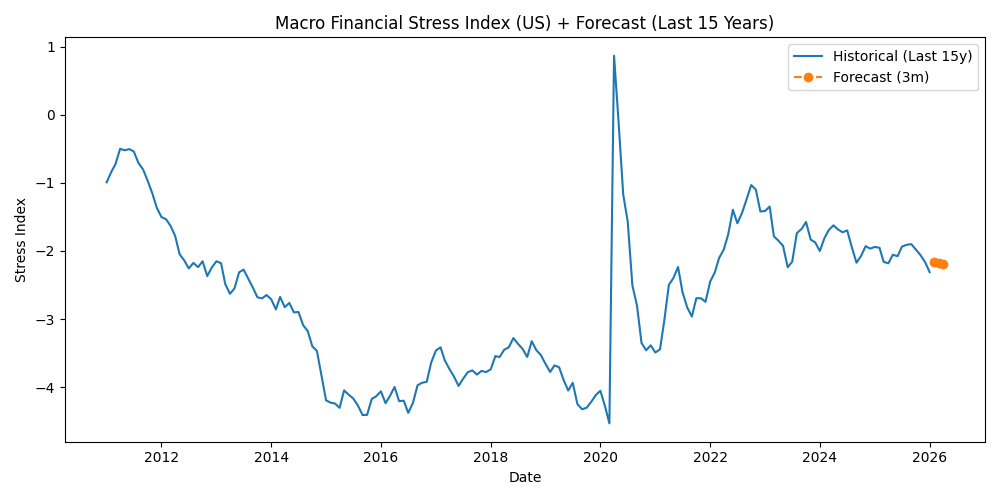

In [4]:
from IPython.display import Image, display
display(Image(filename="../reports/macro_stress_index_recent.png"))

## Automation & Reporting

The full workflow is automated via the `run_pipeline.py` script, which executes:

1. API data ingestion (FRED)
2. Data cleaning and monthly standardization
3. Feature engineering (MoM, YoY, Rolling)
4. Rule-based risk scoring and regime classification
5. SQLite database storage
6. SQL-based executive queries
7. Excel report generation
8. PDF executive briefing
9. Logging

Key deliverables produced:

- Excel Report: `reports/macro_us_report.xlsx`
- Executive PDF: `reports/macro_us_executive_brief.pdf`
- SQLite Database: `data/processed/macro.db`
- Automation Log: `logs/automation.log`

In [5]:
log_path = "../logs/automation.log"

with open(log_path, "r", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()

print("".join(lines[-20:]))

2026-02-18 21:24:57,024 | INFO | Running sql_store_and_query.py
2026-02-18 21:24:57,711 | INFO | ✅ SQLite DB: ../data/processed/macro.db
✅ SQL outputs:
 - data/processed/sql_snapshot.csv
 - data/processed/sql_last12.csv
2026-02-18 21:24:57,712 | INFO | Running us_macro_index.py
2026-02-18 21:24:59,380 | INFO | ✅ Macro Financial Stress Index Created
          date  macro_stress_index stress_level
763 2025-08-01           -1.909953     VERY LOW
764 2025-09-01           -1.900960     VERY LOW
766 2025-11-01           -2.061555     VERY LOW
767 2025-12-01           -2.162323     VERY LOW
768 2026-01-01           -2.312239     VERY LOW
✅ Chart with forecast saved to reports/macro_stress_index.png
✅ Forecast chart saved.
2026-02-18 21:24:59,380 | INFO | Running us_excel_report.py
2026-02-18 21:25:00,913 | INFO | ✅ Excel Report Generated: ../reports/macro_us_report.xlsx
2026-02-18 21:25:00,913 | INFO | Running us_pdf_report.py
2026-02-18 21:25:01,665 | INFO | ✅ PDF updated with forecast inter